In [85]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import importlib
import util # my utility functions
from util import ALL_BEAT_CLASSES, SAMPLING_FREQUENCY, N_PATIENTS
import preprocess as pp # my data preprocessing functions
import train
from train import MostFrequentLabelBaseline, KMeansBaseline
importlib.reload(util)
importlib.reload(pp)
importlib.reload(train)

<module 'train' from '/Users/antonioglenn/Desktop/code-and-projects/my-ecg/train.py'>

# Load Patient ECG Data


In [2]:
N_PATIENTS = 48 
SAMPLING_RATE = 360 # Hz

ALL_BEAT_CLASSES = {"N": "Normal beat",
                    "L": "Left bundle branch block beat",
                    "R": "Right bundle branch block beat",
                    "A": "Atrial premature beat",
                    "S": "Premature or ectopic supraventricular beat",
                    "V": "Premature ventricular contraction",
                    "e": "Atrial escape beat", 
                    "n": "Supraventricular escape beat",
                    "E": "Ventricular escape beat",
                    "Q": "Unclassifiable beat"}

classes = list(ALL_BEAT_CLASSES.keys())
windowDuration = 0.44 # seconds
windowWidthSamples = int(windowDuration * SAMPLING_RATE)
pathSmallData = "small_test_database/"
filename = "mitbih"
#X_dict, y_dict = util.generate_data(windowWidthSamples, classes, path)
X_dict, y_dict = util.load_data(filename)

#util.save_data(X_dict,y_dict,"mitbih")


# Convert dictionary data into flat numpy array: 

``` python
X_dict(patientId: (nBeats,ecgWindowSize)) -> X(nBeats,ecgWindowSize)
Y_dict(patientID: (nBeats,)) -> Y(nBeats, )
```

In [62]:
includedArrhythmias = ["N","R","L","V"]
X,y = util.generate_numpy_from_dict(X_dict,y_dict, includedArrhythmias)
print(f"X shape = {X.shape}\nY shape = {y.shape}")

X shape = (97518, 315)
Y shape = (97518, 1)


# Exploratory Data Analysis

Let's get an idea of the class breakdown in the dataset

{'N': 0.7696015094649193, 'V': 0.07315572509690518, 'L': 0.0827949711848069, 'R': 0.07444779425336862}


Text(0.5, 1.0, 'ECG Beat Class Breakdown')

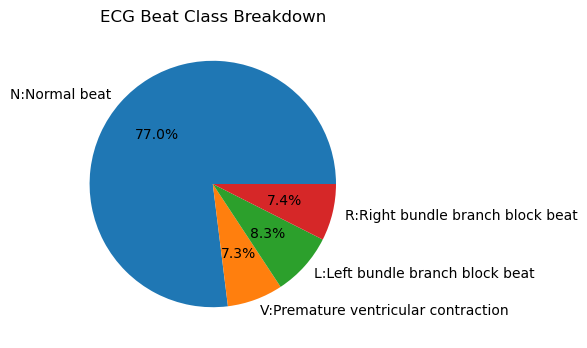

In [4]:
class_percent = pp.class_breakdown(y,.05)
percentages = class_percent.values()
classes = [beat_class + ':' + ALL_BEAT_CLASSES[beat_class] for beat_class in class_percent.keys()]

print(class_percent)
fig,ax = plt.subplots(figsize=(4, 4))
ax.pie(class_percent.values(),labels=classes,autopct='%1.1f%%')
ax.set_title("ECG Beat Class Breakdown")

In [19]:
labels, counts = np.unique(y,return_counts=True)
max_label = np.argmax(counts)
print(labels[max_label],counts[max_label])
print(labels,counts)
len(np.unique(y))

N 75050
['L' 'N' 'R' 'V'] [ 8074 75050  7260  7134]


4

# Lets examine some patient beats 

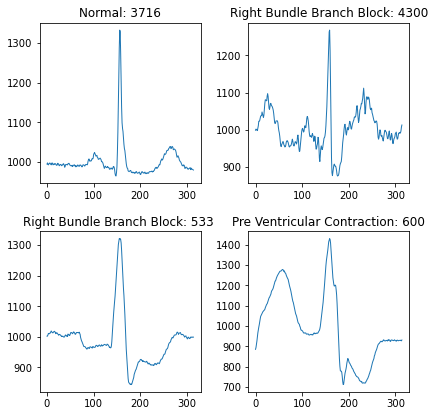

In [7]:
from numpy.random import randint

Normal = util.get_arrhythmia(X,y,"N")
RBB = util.get_arrhythmia(X,y,"R")
LBB = util.get_arrhythmia(X,y,"L")
PVC = util.get_arrhythmia(X,y,"V")

Normal_Beat = 3716 #randint(0,len(Normal))
RBB_Beat = 4300 #randint(0,len(RBB))
LBB_Beat = 533 #randint(0,len(LBB))
PVC_Beat = 600 #randint(0,len(PVC))

fig,((axN,axR),(axL,axV)) = plt.subplots(2,2,figsize=(6,6))

# Normal Beats
axN.plot(Normal[Normal_Beat])
axN.set_title(f"Normal: {Normal_Beat}")
# Right Bundle Branch Block
axR.plot(RBB[RBB_Beat])
axR.set_title(f"Right Bundle Branch Block: {RBB_Beat}")
# Left Bundle Branch Block
axL.plot(LBB[LBB_Beat])
axL.set_title(f"Right Bundle Branch Block: {LBB_Beat} ")
# Pre Ventricular Contraction
axV.plot(PVC[PVC_Beat])
axV.set_title(f"Pre Ventricular Contraction: {PVC_Beat}")

fig.tight_layout(pad=1.5)

# Generate Train and Test Data

Because of the overrepresentation Normal Beats, lets stratify to maintain class ratio

In [63]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,stratify=y)

print(f"X_train {X_train.shape}")
print(f"y_train {y_train.shape}")
print(f"X_test {X_test.shape}")
print(f"y_test {y_test.shape}")

X_train (78014, 315)
y_train (78014, 1)
X_test (19504, 315)
y_test (19504, 1)


# Data Preprocessing Pipeline

## Filter Data and Standardize; Encode Labels

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Filter Input Data
X_train = np.apply_along_axis(pp.movingAverageFilter,1,X_train,5,'valid') # Moving Averager
X_test = np.apply_along_axis(pp.movingAverageFilter,1,X_test,5,'valid') # Moving Averager

# Standardize 
scaler_train = StandardScaler()
scaler_test = StandardScaler()
X_train = scaler_train.fit_transform(X_train.T).T
X_test = scaler_test.fit_transform(X_test.T).T



# Encode Class Labels as Numbers
encoder_train = LabelEncoder()
encoder_test = LabelEncoder()
y_train_encoded = encoder_train.fit_transform(np.ravel(y_train)) # encoder expects 1D array
y_test_encoded = encoder_test.fit_transform(np.ravel(y_test)) # encoder expects 1D array


#encoder.inverse_transform(y_train_encoded[:10])

"""
fig,ax1 = plt.subplots(figsize=(5,5))
index = 489
fig.suptitle(y_train[index], fontsize=16)
#ax1.plot(X_reshaped[index],'b')
#ax1.tick_params(axis="y", labelcolor="blue")
ax2 = ax1.twinx() # create another y-axis sharing a common x-axis
ax2.plot(X_train[index],'g')
ax2.tick_params(axis="y", labelcolor="green")
fig.legend(["Scaled", "Unscaled"])
"""

'\nfig,ax1 = plt.subplots(figsize=(5,5))\nindex = 489\nfig.suptitle(y_train[index], fontsize=16)\n#ax1.plot(X_reshaped[index],\'b\')\n#ax1.tick_params(axis="y", labelcolor="blue")\nax2 = ax1.twinx() # create another y-axis sharing a common x-axis\nax2.plot(X_train[index],\'g\')\nax2.tick_params(axis="y", labelcolor="green")\nfig.legend(["Scaled", "Unscaled"])\n'

# Train this Shit

## Logistic Regression (This sucks)

In [ ]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial",solver='lbfgs',C=1,max_iter=1000)
softmax_reg.fit(X_train_scaled,y_train_encoded)

# Naive Most Frequent Label Classifier

In [30]:
from sklearn.model_selection import cross_val_score
mfl_baseline = MostFrequentLabelBaseline()
mfl_baseline.fit(X_train,y_train)

cross_val_score(mfl_baseline, X_train,y_train,cv=3,scoring="accuracy") # this performance makes sense since 'N' ~ 77% of data

array([0.76608345, 0.77208229, 0.77065067])

# K Nearest Neighbors

Because of high dimensionality (width of the ECG window) we may have to do some PCA to reduce the feature space.

In [119]:
from sklearn.cluster import KMeans
n_clusters = len(np.unique(labels))
kmeans_baseline= KMeans(n_clusters=4,n_init="auto")
kmeans_baseline.fit(X_train,y_train)

KMeans(n_clusters=4, n_init='auto')

In [126]:
#cross_val_score(kmeans_baseline, X_train,y_train,cv=3,scoring='accuracy')
sample = util.getSingleSample(X_train,y_train,10,"N").reshape(1,-1)
#sample.shape
prediction = kmeans_baseline.predict(sample)
print(prediction)
print(np.unique(kmeans_baseline.labels_))
print(kmeans_baseline.get_feature_names_out())

[3]
[0 1 2 3]
['kmeans0' 'kmeans1' 'kmeans2' 'kmeans3']


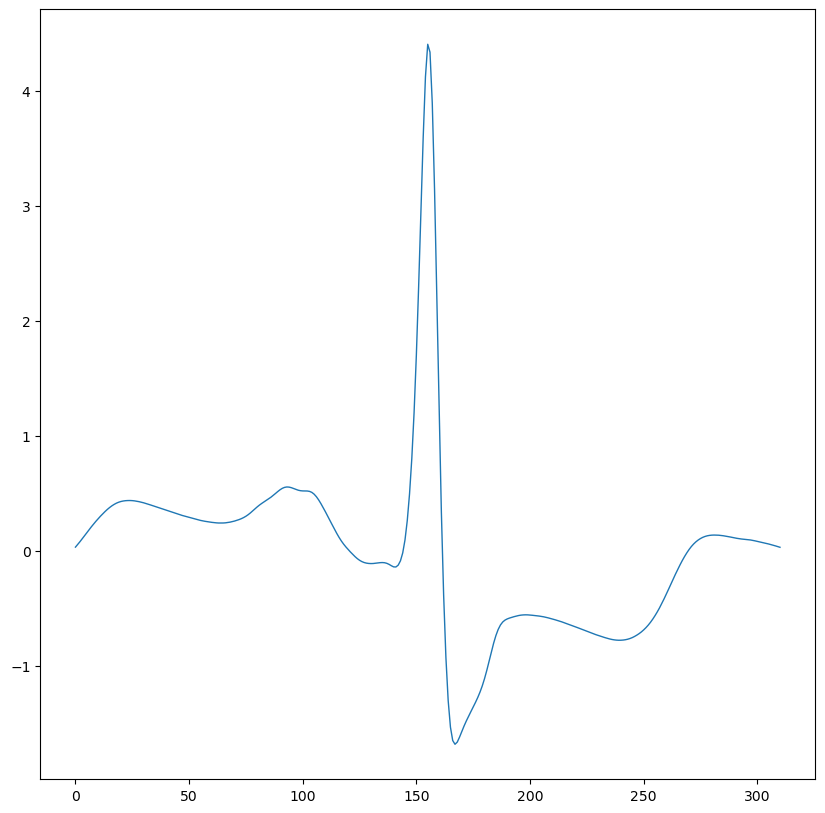

In [138]:
plt.plot(kmeans_baseline.cluster_centers_[0,:])

## 1D CNN 

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train)

# Reshape Data into (batch_size, vector_length, timestep)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)) 

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")


X_train: (62411, 311)
y_train: (62411,)
X_val: (15603, 311)
y_val: (15603,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model = Sequential()
model.add(Conv1D(filters=20, kernel_size=30, activation='relu', input_shape=(311, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=20, kernel_size=30, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 282, 20)           620       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 141, 20)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 112, 20)           12020     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 56, 20)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1120)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               112100    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [20]:
model.fit(x_train_dummy, y_train, validation_data=(x_val_dummy, y_val), epochs=5, batch_size=50)

Train on 62411 samples, validate on 15603 samples
Epoch 1/5
62411/62411 [==============================] - 116s 2ms/sample - loss: 0.0614 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0177 - val_sparse_categorical_accuracy: 0.9942
Epoch 2/5
62411/62411 [==============================] - 116s 2ms/sample - loss: 0.0194 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0134 - val_sparse_categorical_accuracy: 0.9960
Epoch 3/5
62411/62411 [==============================] - 115s 2ms/sample - loss: 0.0140 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0123 - val_sparse_categorical_accuracy: 0.9963
Epoch 4/5
62411/62411 [==============================] - 122s 2ms/sample - loss: 0.0105 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0114 - val_sparse_categorical_accuracy: 0.9967
Epoch 5/5
62411/62411 [==============================] - 117s 2ms/sample - loss: 0.0095 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0131 - val_sparse_categorical_accuracy: 0.9969


# Evaluate Model on Test Data

In [29]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

test_loss, test_accuracy = model.evaluate(x_test_dummy,y_test,verbose=2)

19504/1 - 15s - loss: 0.0046 - sparse_categorical_accuracy: 0.9975


# See a few examples of model performance

N


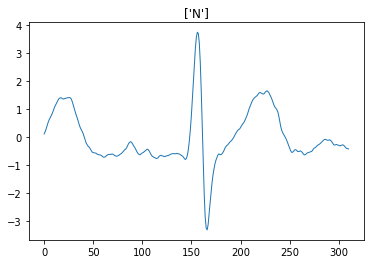

In [82]:
beat_index = 100
class_index = 3 # 0 = L; 1 = N; 2 = R; 3 = V
beat_num = np.where(y_test == class_index)[0][beat_index] 
test_sample = np.reshape(X_test[beat_num],[1,311,1])
plt.plot(X_test[beat_num])
plt.title(encoder_test.inverse_transform([y_test[beat_num]])[0],{"color":'w','fontsize':16})
class_prediction = np.argmax(model.predict(test_sample))
print(f"Model Prediction = {encoder_test.classes_[classb_prediction]}")

# Save Model

In [ ]:
tf.saved_model.save(model,"trained_ECG")

# Convert model to Tensorflow lite

In [94]:
# Convert the model

converter = tf.lite.TFLiteConverter.from_saved_model('CNN/trained_ECGG')
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

# Visualize difference in file sizes

This command lets you view file sizes
```bash
du -lh filename
```

In [96]:
!du -lh trained_ECG/

du: trained_ECG/: No such file or directory


In [99]:
!du -lh model.tflite

496K	model.tflite


In [ ]:
z